# Model Selection

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.cross_validation import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.cluster.bicluster import SpectralBiclustering
                                      
%matplotlib inline

In [35]:
df = pd.read_csv('sample_data.csv')

In [36]:
star_counts = dict(df.star_rating.value_counts())

In [38]:
star_word_counts = df.groupby(['star_rating']).sum().T

In [39]:
for k,v in star_counts.items():
    star_word_counts[k] = groups[k]/v

In [40]:
star_word_counts.sort([5],ascending=False).head(30)

/Users/justinstewart/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


star_rating,1,2,3,4,5
great,0.114424,0.237089,0.353175,0.539394,0.583479
place,0.500403,0.647887,0.584921,0.574242,0.496132
food,0.534247,0.793427,0.680159,0.562121,0.436736
good,0.280419,0.637324,0.867460,0.721970,0.389069
time,0.445608,0.444836,0.367460,0.307197,0.329174
service,0.438356,0.484742,0.353175,0.313258,0.316446
like,0.402901,0.610329,0.541270,0.430682,0.309209
one,0.467365,0.471831,0.383333,0.358333,0.284253
best,0.064464,0.123239,0.134127,0.158712,0.282256
love,0.044319,0.116197,0.114286,0.167045,0.273272


### test 

In [64]:
test = df[['great','good','service']]
y = df['star_rating']
X_train, X_test, y_train, y_test = train_test_split(test,y,test_size=.30,random_state=1,stratify=y)
mnb = MultinomialNB(fit_prior=False).fit(X_train,y_train)
mnb.score(X_test,y_test)



0.29966666666666669

In [48]:
probs = mnb.feature_log_prob_
preds = mnb.predict(X_test)

In [49]:
print y_test[15:25].tolist()
print list(preds [15:25])
print probs
print np.exp(mnb.class_log_prior_)
print test[15:25]


[4, 3, 4, 3, 5, 5, 3, 5, 5, 3]
[5, 1, 1, 3, 3, 4, 5, 1, 5, 1]
[[-1.98424928 -1.10251093 -0.63397322]
 [-1.77445372 -0.76285281 -1.01035481]
 [-1.53850612 -0.57649692 -1.49863373]
 [-1.07766911 -0.75912118 -1.6526879 ]
 [-0.80202654 -1.16659545 -1.4264695 ]]
[ 0.2  0.2  0.2  0.2  0.2]
    great  good  service
15      0     1        1
16      0     0        0
17      0     0        0
18      1     1        0
19      2     0        0
20      0     0        0
21      0     0        0
22      1     1        0
23      0     1        0
24      0     0        0


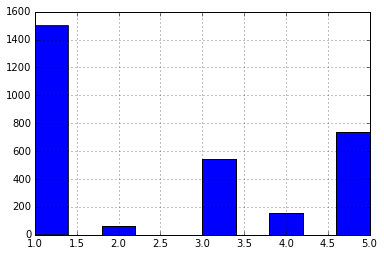

In [50]:
pd.Series(preds).hist()

# Training a classifier

### Train-Test split

Need to split the dataset into train and test, then use cross val to traing the classifier.

In [66]:
X = df.drop('star_rating',axis=1).as_matrix()

In [70]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.30,
                                                    random_state=1,stratify=y)

### true values

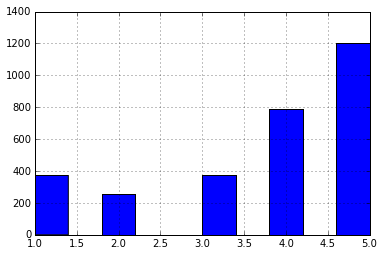

In [71]:
pd.Series(y_test).hist()

### baseline - highest frequency

In [72]:
dummy = DummyClassifier(strategy='most_frequent', random_state=1) 

In [73]:
dummy.fit(X_train,y_train)

DummyClassifier(constant=None, random_state=1, strategy='most_frequent')

In [74]:
preds = dummy.predict(X_test)

In [75]:
dummy.score(X_test,y_test)

0.40066666666666667

### informed prior

In [76]:
mnb = MultinomialNB(fit_prior=True).fit(X_train,y_train)

In [77]:
np.exp(mnb.class_log_prior_)

array([ 0.12414286,  0.08514286,  0.126     ,  0.264     ,  0.40071429])

In [78]:
preds = mnb.predict(X_test)

In [79]:
mnb.score(X_test,y_test)

0.54833333333333334

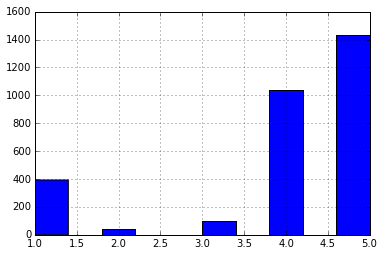

In [80]:
pd.Series(preds).hist()

### uniformative prior

In [81]:
mnb = MultinomialNB(fit_prior=False).fit(X_train,y_train)

In [82]:
np.exp(mnb.class_log_prior_)

array([ 0.2,  0.2,  0.2,  0.2,  0.2])

In [83]:
preds = mnb.predict(X_test)

In [84]:
mnb.score(X_test,y_test)

0.55233333333333334

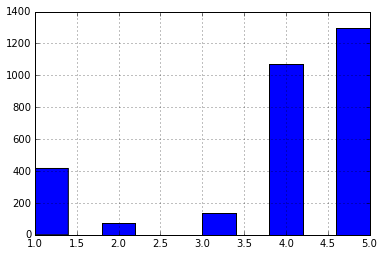

In [85]:
pd.Series(preds).hist()

# Feature Engineering: clustering

In [117]:
# word_sim = np.corrcoef(groups.as_matrix())

In [106]:
star_word_counts_max = star_word_counts.sort_values(by=[5],ascending=False)
star_word_counts_max['maxes'] = star_word_counts_max.apply(max,axis=1)
frequent_words = star_word_counts_max[star_word_counts_max.maxes >= 0.5]

In [108]:
frequent_words.drop(['maxes'],inplace=True,axis=1)

/Users/justinstewart/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [109]:
word_sim = np.corrcoef(frequent_words.as_matrix())

In [138]:
spec = SpectralBiclustering(n_clusters=3)

In [139]:
spec.fit(word_sim)

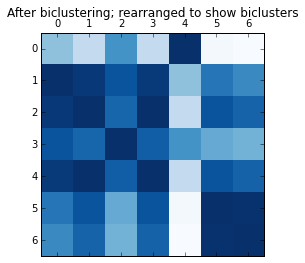

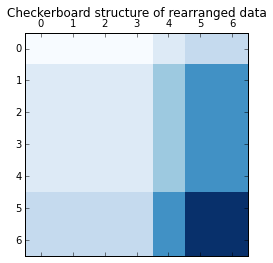

In [140]:
fit_data = word_sim[np.argsort(spec.row_labels_)]
fit_data = fit_data[:, np.argsort(spec.column_labels_)]

plt.matshow(fit_data, cmap=plt.cm.Blues)
plt.title("After biclustering; rearranged to show biclusters")

plt.matshow(np.outer(np.sort(spec.row_labels_) + 1,
                     np.sort(spec.column_labels_) + 1),
            cmap=plt.cm.Blues)
plt.title("Checkerboard structure of rearranged data")

plt.show()

### Accuracy Metrics

importnatn to consider what is the best accuracy measure to use to test results. notice that star rating is a ordered 